## CRISP-DM Phase 3. Data Preparation

The data preparation phase covers all activities needed to construct the final dataset [data that will be fed into the modeling tool(s)] from the initial raw data. Tasks include table, record, and attribute selection, as well as transformation and cleaning of data for modeling tools

In [3]:
import sys
sys.path.append('../src')
import utils
import data_processor
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import warnings 
warnings.filterwarnings('ignore')

# Load data
df: pd.DataFrame = utils.load_original_data()

# Data preprocessing object
processor = data_processor.DataProcessor(df)

### Converting Target Variable into binary values in conformance with a classification problem

In [4]:
# Convert Financial Distress column into 0 or 1
df['Financial Distress'] = [0 if x > -0.50 else 1 for x in df['Financial Distress']]

df.head()

,Company,Time,Financial Distress,x1,x2,x3,x4,x5,x6,x7,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
0,1,1,0,1.2810,0.022934,0.87454,1.21640,0.060940,0.188270,0.52510,...,85.437,27.07,26.102,16.000,16.0,0.2,22,0.060390,30,49
1,1,2,0,1.2700,0.006454,0.82067,1.00490,-0.014080,0.181040,0.62288,...,107.090,31.31,30.194,17.000,16.0,0.4,22,0.010636,31,50
2,1,3,0,1.0529,-0.059379,0.92242,0.72926,0.020476,0.044865,0.43292,...,120.870,36.07,35.273,17.000,15.0,-0.2,22,-0.455970,32,51
3,1,4,1,1.1131,-0.015229,0.85888,0.80974,0.076037,0.091033,0.67546,...,54.806,39.80,38.377,17.167,16.0,5.6,22,-0.325390,33,52
4,2,1,0,1.0623,0.107020,0.81460,0.83593,0.199960,0.047800,0.74200,...,85.437,27.07,26.102,16.000,16.0,0.2,29,1.251000,7,27


In [5]:
# Create feature matrix and target vector 
X, y = processor.create_feature_matrix_and_target_vector("Financial Distress")

### Balancing Data

Two different techniques were combined to address class imbalance:
- SMOTE: Oversample the minority class  
- Random Undersampling: Undersample the majority class 

Counter({0: 3536, 1: 136})


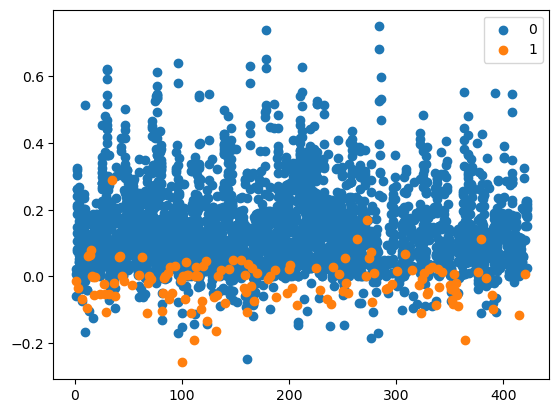

In [6]:
# Check class distribution
processor.class_distribution(X,y)

How the SMOTE synthesizes new examples for the minority class:
- SMOTE first selects a minority class instance at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b.

Counter({0: 2120, 1: 1060})


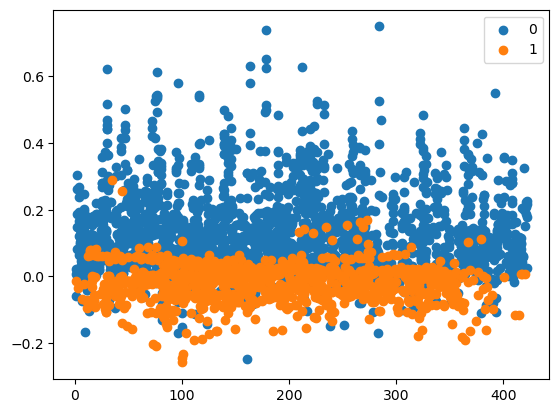

In [7]:
# Transform data with SMOTE for minority class and RandomUnderSampler for majority class to tackle class imbalance
X_sampled, y_sampled = processor.transform(X, y,0.3,0.5)

- The final class distribution after this sequence of transforms matches expectations with a 1:2 ratio or about 2,000 examples in the majority class and about 1,000 examples in the minority class.

In [8]:
sampled_sorted = X_sampled.sort_values(by=['Company'])
sampled_sorted

,Company,Time,x1,x2,x3,x4,x5,x6,x7,x8,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
2,1,3,1.0529,-0.059379,0.92242,0.72926,0.020476,0.044865,0.43292,-0.081423,...,120.870,36.07,35.273,17.000,15.0,-0.2,22,-0.455970,32,51
1,1,2,1.2700,0.006454,0.82067,1.00490,-0.014080,0.181040,0.62288,0.006423,...,107.090,31.31,30.194,17.000,16.0,0.4,22,0.010636,31,50
3,1,4,1.1131,-0.015229,0.85888,0.80974,0.076037,0.091033,0.67546,-0.018807,...,54.806,39.80,38.377,17.167,16.0,5.6,22,-0.325390,33,52
0,1,1,1.2810,0.022934,0.87454,1.21640,0.060940,0.188270,0.52510,0.018854,...,85.437,27.07,26.102,16.000,16.0,0.2,22,0.060390,30,49
16,2,13,2.0924,0.303480,0.43822,0.99193,0.426300,0.465320,1.49120,0.305950,...,92.900,203.20,204.500,22.000,22.0,6.4,29,2.941300,19,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3659,421,10,1.8390,0.207880,0.72381,0.67291,0.213390,0.154050,1.77080,0.308930,...,100.000,100.00,100.000,17.125,14.5,-7.0,37,8.132900,2,9
3671,422,14,1.6148,0.176760,0.36369,0.18442,0.169550,0.197860,1.58420,0.958450,...,91.700,227.50,214.500,21.000,20.5,8.6,37,0.611030,8,45
3668,422,11,1.9615,0.216440,0.20095,0.21642,0.203590,0.189870,1.93820,1.000100,...,91.500,130.50,132.400,20.000,14.5,-16.0,37,0.438020,5,42
3664,422,7,1.3449,0.026538,0.24533,0.03792,0.026432,0.083908,1.27210,0.699840,...,79.951,66.12,59.471,18.000,12.0,-13.4,37,0.107580,1,38


In [9]:
# check if Time is monotonic and increasing for each group/company 
print("Time monotonic and increasing for each group/company in original data: {}".format(processor.check_time_monotonicity(X, "Time")))
print("Time monotonic and increasing for each group/company in sampled data: {}".format(processor.check_time_monotonicity(X_sampled, "Time")))

Time monotonic and increasing for each group/company in original data: True
Time monotonic and increasing for each group/company in sampled data: False


- It seems that the temporal order of the 'Time' column is not being preserved within each group (company) in the sampled data.

In [10]:
# Preserve temporal order of data for each group/company
X_sampled_sorted = X_sampled.sort_values(by=['Company', 'Time'])
print(X_sampled_sorted.head())

# sort y_sampled according to X_sampled_sorted 
y_sampled_sorted = y_sampled[X_sampled_sorted.index]
# reset index
y_sampled_sorted = y_sampled_sorted.reset_index(drop=True)
print(y_sampled_sorted.head())

   Company  Time      x1        x2       x3       x4        x5        x6  \
0        1     1  1.2810  0.022934  0.87454  1.21640  0.060940  0.188270   
1        1     2  1.2700  0.006454  0.82067  1.00490 -0.014080  0.181040   
2        1     3  1.0529 -0.059379  0.92242  0.72926  0.020476  0.044865   
3        1     4  1.1131 -0.015229  0.85888  0.80974  0.076037  0.091033   
5        2     2  1.0558  0.081916  0.87949  0.68673  0.142630  0.043102   

        x7        x8  ...      x74    x75     x76     x77   x78  x79  x80  \
0  0.52510  0.018854  ...   85.437  27.07  26.102  16.000  16.0  0.2   22   
1  0.62288  0.006423  ...  107.090  31.31  30.194  17.000  16.0  0.4   22   
2  0.43292 -0.081423  ...  120.870  36.07  35.273  17.000  15.0 -0.2   22   
3  0.67546 -0.018807  ...   54.806  39.80  38.377  17.167  16.0  5.6   22   
5  0.77198  0.119280  ...  107.090  31.31  30.194  17.000  16.0  0.4   29   

        x81  x82  x83  
0  0.060390   30   49  
1  0.010636   31   50  
2 -0.455

In [11]:
# sum of null values in X_sampled and y_sampled
print("Number of NaN values in X_sampled: {}".format(X_sampled_sorted.isnull().sum().sum()))
print("Number of NaN values in y_sampled: {}".format(y_sampled_sorted.isnull().sum().sum()))

Number of NaN values in X_sampled: 0
Number of NaN values in y_sampled: 0


### Scaling

In [12]:
X_scaled : pd.DataFrame = processor.scale(X_sampled_sorted)
X_scaled

,Company,Time,x1,x2,x3,x4,x5,x6,x7,x8,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
0,-1.618671,-1.538426,0.009097,-0.480535,1.139443,0.738387,-0.373032,0.590499,-0.175492,-0.049636,...,-0.129509,-0.973952,-0.949535,-0.880667,0.240018,0.312100,0.388672,-0.430383,1.794448,1.194721
1,-1.618671,-1.296550,0.001210,-0.612208,0.835546,0.342095,-0.954401,0.554947,-0.077971,-0.049638,...,1.220160,-0.909748,-0.887114,-0.392229,0.240018,0.337524,0.388672,-0.461037,1.903866,1.272101
2,-1.618671,-1.054673,-0.154440,-1.138213,1.409549,-0.174376,-0.686609,-0.114652,-0.267427,-0.049649,...,2.079091,-0.837669,-0.809637,-0.392229,-0.099566,0.261251,0.388672,-0.748527,2.013283,1.349481
3,-1.618671,-0.812797,-0.111280,-0.785456,1.051100,-0.023580,-0.256037,0.112365,-0.025531,-0.049641,...,-2.038792,-0.781187,-0.762287,-0.310660,0.240018,0.998564,0.388672,-0.668073,2.122701,1.426861
4,-1.609799,-1.296550,-0.152361,-0.009272,1.167367,-0.254066,0.260028,-0.123321,0.070733,-0.049624,...,1.220160,-0.909748,-0.887114,-0.392229,0.240018,0.337524,1.406298,0.368680,-0.612738,-0.430263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3175,2.107768,1.605969,-0.388503,0.837935,0.452219,-0.318147,0.646264,-0.927587,-0.080086,-0.049603,...,0.260875,2.061071,1.924361,1.561523,1.768143,1.379933,2.569298,3.996258,-0.831574,-1.590966
3176,2.116640,-0.087167,0.054910,-0.451740,-2.410125,-1.469753,-0.640452,0.077330,0.569525,-0.049551,...,-0.471461,-0.382635,-0.440511,0.096209,-1.118316,-1.416773,2.569298,-0.401307,-1.378661,0.343539
3177,2.116640,0.396586,0.944002,1.153219,-2.955696,-1.287065,0.119374,0.802430,1.833659,-0.049427,...,0.396945,-0.137629,-0.211299,-0.636448,-0.778732,0.362949,2.569298,-0.162219,-1.159826,0.498299
3178,2.116640,0.880339,0.496982,1.065569,-2.660486,-1.135294,0.732439,0.598366,1.233856,-0.049513,...,0.248408,0.592243,0.671976,1.073085,-0.269357,-1.747292,2.569298,-0.197714,-0.940991,0.653060


### Feature Selection

#### Recursive Feature Selection

In [13]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=10)
rfe.fit(X_scaled, y_sampled_sorted)
print("Selected features after RFE: {}".format(X_scaled.columns[rfe.support_]))

Selected features after RFE: Index(['x2', 'x10', 'x14', 'x36', 'x46'], dtype='object')


### Save Data

In [26]:
# Append X and Y to create a single data frame
df_model = pd.DataFrame(X_scaled)
df_model['Financial Distress'] = y_sampled_sorted

# save data
with open('../data/processed/financial_data_processed.pkl', 'wb') as f:
    pkl.dump(df_model, f)